In [1]:
import os
import joblib
from pathlib import Path
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from model_settings import ms
from quantlib_pricers import barriers, asians

ms.find_root(Path())
ms.__dict__

modelsdir = os.path.join(ms.root,ms.trained_models)
folders = [f for f in os.listdir(modelsdir) if f.find('Legacy')==-1 and not f.startswith('.')]
folders

['2024-11-15 164145753233 cboe spx relative asian',
 '2024-11-15 164315824655 cboe spx relative barrier']

In [2]:
model_folder = folders[0]
pricename = str(model_folder[model_folder.rfind(' ')+1:])+'_price'
model_dir = os.path.join(modelsdir,model_folder)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl') and f.find(model_folder)!=-1][0]
model = joblib.load(os.path.join(model_dir,pickle))
est = model['model']
df = model['train_data'].iloc[:,:-4].copy().reset_index(drop=True)
df = df.drop(columns=[c for c in df.columns if c.find(pricename)!=-1])
if pricename == 'barrier_price':
    pricer = barriers.df_barrier_price

elif pricename == 'asian_price':
    pricer = asians.df_asian_option_price

pricer

<bound method asian_option_pricer.df_asian_option_price of <quantlib_pricers.asian_option_pricer.asian_option_pricer object at 0x0000020C22216C90>>

In [3]:
feature_set = model['feature_set']
feature_set

['days_to_maturity',
 'fixing_frequency',
 'past_fixings',
 'risk_free_rate',
 'dividend_rate',
 'kappa',
 'theta',
 'rho',
 'eta',
 'v0',
 'relative_spot',
 'averaging_type',
 'w']

In [4]:
file = [f for f  in os.listdir(Path()) if f.find(pricename[:pricename.find('_')]) !=-1 ][0]

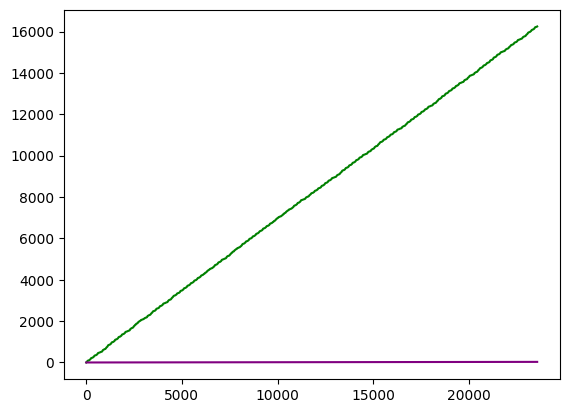

asian_cpu    16246.420247
MLP_cpu         29.064395
Name: 23579, dtype: float64
99.8211% gain in computational efficiency


In [5]:
df = pd.read_csv(os.path.join(Path(),file)).iloc[:,1:].copy()
times = df[[pricename.replace('price','cpu'),'MLP_cpu']].cumsum()
plt.figure()
plt.plot(times.iloc[:,0],label='original pricing function',color='green')
plt.plot(times.iloc[:,1],label='multilayer perception',color='purple')
plt.show()
totals = times.iloc[-1]
print(totals)
original = totals[pricename.replace('price','cpu')]
mlp = totals['MLP_cpu']
gain = 1-mlp/original
print(f"{round(gain*100,4)}% gain in computational efficiency")